<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données et librairies**



In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import TimeDistributed
from keras.layers import Conv3D, Conv2D,BatchNormalization,MaxPooling2D , MaxPooling3D, GlobalMaxPool2D,GlobalMaxPool3D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

Pour l'import des datasets on crée une fonction dont les paramètres sont les chemins des fichiers hdf5 que l'on souhaite utiliser pour l'apprentissage.

Les fichiers hdf5 sont générés par le notebook "pre_processing.ipynb". 
Pour faire notre choix de pré-processing, il suffit de choisir les fichiers hdf5 dont les méthodes du notebook sont indiquées dans le nom du fichier : 
"dataset_..._methode_num1_num2"

In [31]:
def importation(path_normal, path_malade):
  hf_normal = h5py.File(path_normal, "r")
  hf_malade = h5py.File(path_malade, "r")

  # conversion des données en tableaux numpy
  Data_normal = np.array(hf_normal["dataset_1"][:])
  Data_malade = np.array(hf_malade["dataset_2"][:])

  return [Data_normal, Data_malade]

# **1 - Etude des données et création des labels**



In [24]:
Dataset = importation("/content/drive/MyDrive/UV PROJET P6/Dataset_normal.hdf5", 
                      "/content/drive/MyDrive/UV PROJET P6/Dataset_malade.hdf5")

In [25]:
Data_normal = Dataset[0]
Data_malade = Dataset[1]
Data_normal.shape, Data_malade.shape

((55720, 48, 48), (54600, 48, 48))

Afin de pouvoir utiliser des séquences dans les modèles suivant, nous modifions la shape des tableaux en créant des séquences de taille 70. 

In [26]:
Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
Data = np.concatenate((Data_normal, Data_malade))
Data.shape

(1576, 70, 48, 48)

Le jeu de données est composé de séquences de 70 images par scan, c'est pourquoi on attribue un label pour chaque séquence :
- 0 : La personne est négative au COVID
- 1 : La personne est positive au COVID

In [27]:
Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
Y = np.concatenate((Y_normal, Y_malade))
Y.shape

(1576,)

Afin de faciliter le traitement pour la suite on encapsule la création des labels dans une fonction :

In [28]:
def labelling(Dataset):
  Data_normal = Dataset[0]
  Data_malade = Dataset[1]
  Data_normal = Data_normal.reshape(Data_normal.shape[0]//70, 70, 48, 48)
  Data_malade = Data_malade.reshape(Data_malade.shape[0]//70, 70, 48, 48)
  Data = np.concatenate((Data_normal, Data_malade))
  Y_normal = np.zeros(Data_normal.shape[0], dtype=np.int8)
  Y_malade = np.ones(Data_malade.shape[0], dtype=np.int8)
  Y = np.concatenate((Y_normal, Y_malade))
  return [Data, Y]

# **2 - Création des modèles d'apprentissage**




## Définition des fonctions globales

#### Fonction de visualisation

In [38]:
def visualisation(model):
  acc = model.history.history['acc']
  val_acc = model.history.history['val_acc']
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']

  print(acc)
  print(val_acc)

  print(loss)
  print(val_loss)

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

#### Fonction d'évaluation du modèle sur un jeu de données aléatoire

In [52]:
def evaluation(dataLength, iterations,model):
  
  for i in range(iterations):
    Data_test = []
    for i in range(dataLength):
      aleatoire = np.random.randint(0, Data_normal.shape[0])
      Data_test.append(Data_normal[aleatoire][:])
    for i in range(dataLength):
      aleatoire = np.random.randint(0, Data_malade.shape[0])
      Data_test.append(Data_malade[aleatoire][:])

    Data_test = np.array(Data_test)
    #Data_test.shape

    Y_test_normal = np.zeros(dataLength)
    Y_test_malade = np.ones(dataLength)
    Y_test = np.concatenate((Y_test_normal, Y_test_malade))
    model.evaluate(Data_test, Y_test)
    preds = np.round(model.predict(Data_test),0)
    cm = confusion_matrix(Y_test, preds)
    print(cm)



### Modèle 3 ...



## Définition des paramètres globaux

In [35]:
SIZE = (48, 48)
NBFRAME = 70
EPOCH = 40
BS = 8
CHANNEL = 1
INSHAPE = (70, 48, 48, 1)


On fixe la graine aléatoire afin que l'on puisse avoir des résultats similaires en relançant l'apprentissage : 

In [36]:
def fix_seed(seed):
    tensorflow.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

## Définition des modèles ▶ Choix à faire



### Modèle 1 : 2DCNN + GRU

In [58]:
def build_convnet2D(shape=(48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [57]:
def action_model2D(shape=(70,48, 48), nbout=1):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet2D(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (70,48,48,3) shape
    model.add(TimeDistributed(convnet, input_shape=(70,48, 48,1)))
    # add the GRU cell
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

### Modèle 2 : 3DCNN




In [70]:
# création du modèle d'apprentissage

def build_convnet3D(shape=(70, 48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(64, (3, 3, 3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling3D())
    
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool3D())
    return model

In [71]:
# création du réseau de décision

def action_model3D(shape=(70, 48, 48, 1), nbout=1):
    convnet = build_convnet3D(shape)
    
    model = keras.Sequential()
    model.add(convnet)
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

# **3 - Apprentissage  des modèles**


## Modèle 1 : Conv2D

▶ run modèle conv2D

In [59]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        min_delta = 0,
        patience = 15,
        verbose = 1,
        restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/myModel2D.h5')
]

In [60]:
model2D = action_model2D(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model2D.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [61]:
model2D.fit(Data, Y, epochs=EPOCH, validation_split=0.2, batch_size=BS, callbacks=my_callbacks)

Epoch 1/40
158/158 [==============================] - 47s 282ms/step - loss: 0.5229 - acc: 0.7825 - val_loss: 0.7642 - val_acc: 0.6646
Epoch 2/40
158/158 [==============================] - 43s 272ms/step - loss: 0.4505 - acc: 0.7849 - val_loss: 0.8853 - val_acc: 0.6709
Epoch 3/40
158/158 [==============================] - 43s 274ms/step - loss: 0.3861 - acc: 0.8413 - val_loss: 0.3718 - val_acc: 0.8513
Epoch 4/40
158/158 [==============================] - 43s 272ms/step - loss: 0.3228 - acc: 0.8683 - val_loss: 0.3865 - val_acc: 0.8544
Epoch 5/40
158/158 [==============================] - 43s 273ms/step - loss: 0.3763 - acc: 0.8381 - val_loss: 0.5273 - val_acc: 0.6203
Epoch 6/40
158/158 [==============================] - 43s 272ms/step - loss: 0.3643 - acc: 0.8429 - val_loss: 0.3913 - val_acc: 0.7405
Epoch 7/40
158/158 [==============================] - 43s 272ms/step - loss: 0.3252 - acc: 0.8706 - val_loss: 0.5409 - val_acc: 0.7120
Epoch 8/40
158/158 [==============================] - 4

On récupère le modèle avec les meilleurs poids epoch 37 : 

In [45]:
model2D_saved = model2D.load_weights("/tmp/myModel2D.h5")

[0.7825396656990051, 0.7849206328392029, 0.841269850730896, 0.8682539463043213, 0.8380952477455139, 0.8428571224212646, 0.870634913444519, 0.855555534362793, 0.8809523582458496, 0.8999999761581421, 0.9126983880996704, 0.9134920835494995, 0.9222221970558167, 0.9150793552398682, 0.9182539582252502, 0.9246031641960144, 0.9341269731521606, 0.9404761791229248, 0.934920608997345, 0.934920608997345, 0.9404761791229248, 0.949999988079071, 0.9523809552192688, 0.9452381134033203, 0.9507936239242554, 0.9420635104179382, 0.9452381134033203, 0.9603174328804016, 0.958730161190033, 0.9412698149681091, 0.9515873193740845, 0.9579365253448486, 0.9436507821083069, 0.958730161190033, 0.9515873193740845, 0.9634920358657837, 0.9579365253448486, 0.9642857313156128, 0.9634920358657837, 0.9055555462837219]
[0.6645569801330566, 0.6708860993385315, 0.8512658476829529, 0.8544303774833679, 0.6202531456947327, 0.7405063509941101, 0.7120253443717957, 0.8860759735107422, 0.7310126423835754, 0.7341772317886353, 0.7056

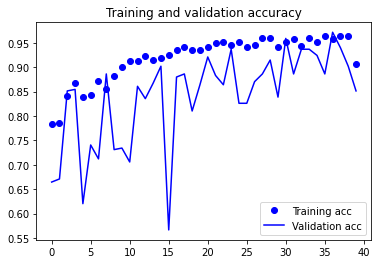

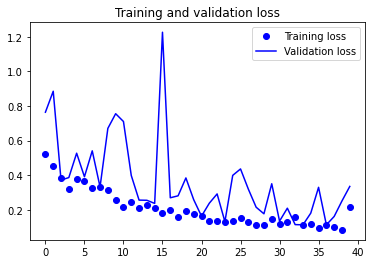

In [62]:
visualisation(model2D)

In [65]:
evaluation(150,2,model2D)

10/10 [==============================] - 2s 194ms/step - loss: 0.2271 - acc: 0.9200
[[146   4]
 [ 20 130]]
10/10 [==============================] - 2s 195ms/step - loss: 0.1756 - acc: 0.9233
[[145   5]
 [ 18 132]]


## Modèle 2 : 3DCNN

▶ run du modèle 3DCNN

In [68]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_acc',
        min_delta = 0,
        patience = 25,
        verbose = 1,
        restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/myModel3D.h5')
]

In [80]:
model3DCNN = action_model3D(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model3DCNN.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

In [81]:
model3DCNN.fit(Data, Y, epochs=EPOCH, validation_split=0.2, batch_size=BS, callbacks=my_callbacks)

Epoch 1/40
158/158 [==============================] - 90s 563ms/step - loss: 0.9944 - acc: 0.5357 - val_loss: 0.8424 - val_acc: 0.0095
Epoch 2/40
158/158 [==============================] - 88s 556ms/step - loss: 0.7133 - acc: 0.5952 - val_loss: 0.9151 - val_acc: 0.0095
Epoch 3/40
158/158 [==============================] - 87s 549ms/step - loss: 0.5820 - acc: 0.7016 - val_loss: 1.1727 - val_acc: 0.0095
Epoch 4/40
158/158 [==============================] - 86s 543ms/step - loss: 0.6547 - acc: 0.6365 - val_loss: 1.0608 - val_acc: 0.0032
Epoch 5/40
158/158 [==============================] - 86s 545ms/step - loss: 0.6130 - acc: 0.7016 - val_loss: 0.9399 - val_acc: 0.0000e+00
Epoch 6/40
158/158 [==============================] - 86s 544ms/step - loss: 0.6252 - acc: 0.6738 - val_loss: 1.1877 - val_acc: 0.2722
Epoch 7/40
158/158 [==============================] - 86s 542ms/step - loss: 0.4474 - acc: 0.8183 - val_loss: 0.4670 - val_acc: 0.8133
Epoch 8/40
158/158 [==============================]

On sauvegarde le modèle avec les meilleurs poids : 

In [82]:
model3D_saved = model3DCNN.load_weights("/tmp/myModel3D.h5")

[0.5357142686843872, 0.5952380895614624, 0.7015873193740845, 0.6365079283714294, 0.7015873193740845, 0.6738095283508301, 0.8182539939880371, 0.8626984357833862, 0.8690476417541504, 0.8849206566810608, 0.8738095164299011, 0.8888888955116272, 0.9023809432983398, 0.9063491821289062, 0.9039682745933533, 0.9190475940704346, 0.9134920835494995, 0.9190475940704346, 0.9277777671813965, 0.9222221970558167, 0.932539701461792, 0.9420635104179382, 0.9301587343215942, 0.9293650984764099, 0.932539701461792, 0.9388889074325562, 0.949999988079071, 0.9444444179534912, 0.9396825432777405, 0.949999988079071, 0.9476190209388733, 0.9555555582046509, 0.9547619223594666, 0.9055555462837219, 0.9309523701667786, 0.9595237970352173, 0.9555555582046509, 0.9642857313156128, 0.9444444179534912, 0.9452381134033203]
[0.009493670426309109, 0.009493670426309109, 0.009493670426309109, 0.0031645570416003466, 0.0, 0.2721518874168396, 0.8132911324501038, 0.8259493708610535, 0.6708860993385315, 0.5284810066223145, 0.813291

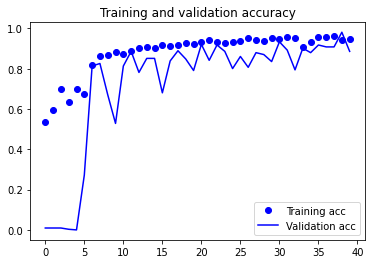

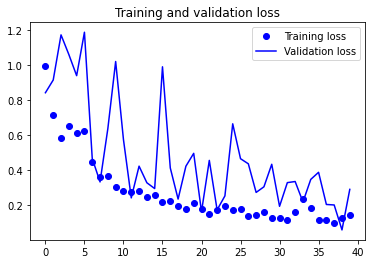

In [83]:
visualisation(model3DCNN)

In [85]:
evaluation(100, 2,model3DCNN)

7/7 [==============================] - 3s 411ms/step - loss: 0.1534 - acc: 0.9400
[[99  1]
 [11 89]]
7/7 [==============================] - 3s 413ms/step - loss: 0.1689 - acc: 0.9350
[[99  1]
 [12 88]]


Le modèle est plus efficace que les modèles 2D, il prédit avec une accuracy de 93,5% sur un jeu de séqurnces aléatoire en test.